# Single Pixel Study

- [MNIST](#MNIST)
- [CIFAR-10](#CIFAR-10)
- [OTHER](#OTHER)

In [2]:
from IPython.display import display
from ipywidgets import FloatProgress

import sys
sys.path.append('../src')

import neuralnetworkclassifier as nnc
import dataset_manipulations as dm
import mlutils as ml
import perturb as per

import pickle, gzip
import numpy as np
import pandas as pd
import itertools
import copy
import pickle
import glob

import matplotlib.pyplot as plt
import matplotlib.pylab as pl

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')

In [2]:
import imp
imp.reload(per);
imp.reload(ml);

In [3]:
Xtrain, Ttrain, Xtest, Ttest, _, _ = dm.load_mnist('mnist.pkl.gz')

In [8]:
XX = np.zeros((3, 2, 10))
XX[0, 1, 1] = 5
print(XX)
XX[2, 1]

[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 5. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [4]:
COLORS = pl.cm.Set2(np.linspace(0, 1, 8))

def augmented_training(Xtrain, Ttrain, Xtest, Ttest, model='MNIST'):

    perturbs = ['stuck', 'dead', 'hot']
    
    test_pixel_change = 2
    trials = 25
    training_pixels = np.linspace(1, 10, 10)
    
    f = FloatProgress(min=0, max=(len(perturbs) * len(training_pixels) * (trials * len(perturbs))))
    display(f)
    
    for i, perturb in enumerate(perturbs):
        
        natural_acc = []
        augmented_acc = np.zeros((len(perturbs), 2, len(training_pixels)))
        
        """
        test_perturb_1
        
               p_1 p_2 p_3 p_4
        mean [[0., 0., 0., 0.],
        std   [0., 0., 0., 0.]],
        
        test_perturn_2
        ...
        
        """
        
        for p, pixels in enumerate(training_pixels):

            Mtrain = per.change_pixel(Xtrain, pixels_to_change=pixels+1, pertrub=perturb)

            if model == 'MNIST':
                nnet = per.train_mnist(Mtrain, Ttrain)
            else:
                nnet = per.train_cifar(Mtrain, Ttrain)
                
            natural_acc.append(ml.percent_correct(ml.batched_use(nnet, Xtest), Ttest))
            
            for t, test_perturb in enumerate(perturbs):
                
                tmp = []
                
                for trial in range(trials):
                    M = per.change_pixel(Xtest, pixels_to_change=test_pixel_change, pertrub=test_perturb)
                    tmp.append(ml.percent_correct(ml.batched_use(nnet, M), Ttest))
                    f.value += 1
                    
                augmented_acc[t, 0, p] = np.mean(tmp)
                augmented_acc[t, 1, p] = np.std(tmp)
        
        print(perturb)
        
        for t, test_perturb in enumerate(perturbs):
        
            plt.errorbar(training_pixels, augmented_acc[t, 0], yerr=augmented_acc[t, 1],
                         marker='.', lw=1, capsize=5, capthick=1.5, label=f'{test_perturb}',
                         markeredgecolor='k', color=COLORS[t])
        
        plt.plot(training_pixels, natural_acc, marker='.', lw=1, label=f'natural',
                 markeredgecolor='k', color=COLORS[3])
        
        plt.xticks(training_pixels)
        plt.xlabel('Num Training Pixel(s)')
        plt.ylabel('Accuracy ( \% )')
        plt.legend(loc='best', fontsize='large')
        plt.grid(True); plt.tight_layout();
        plt.savefig('media/constant/' + model + perturb + '.pdf', bbox_inches='tight')
        plt.show();

FloatProgress(value=0.0, max=2250.0)

stuck


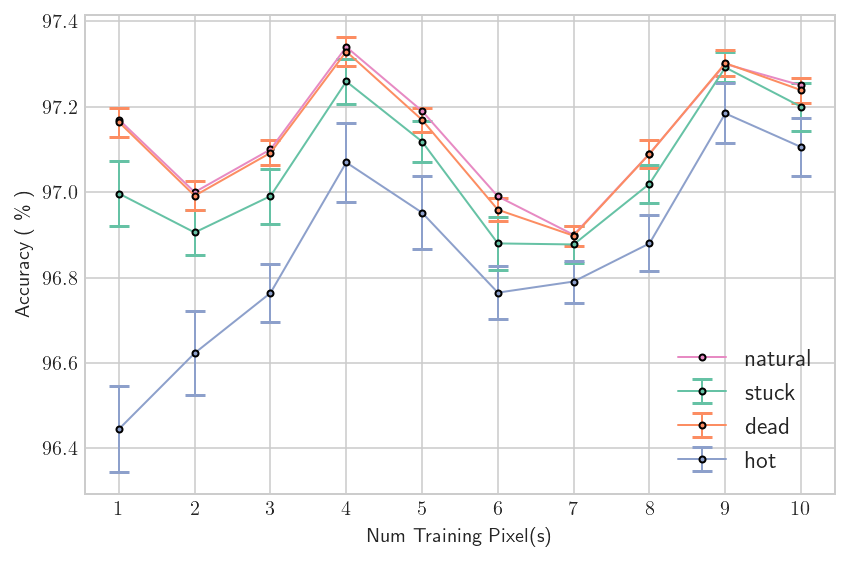

dead


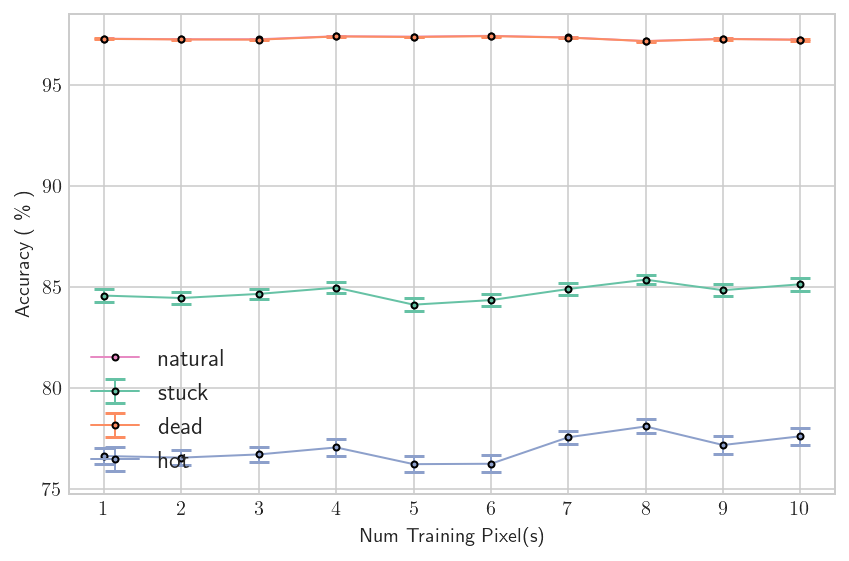

hot


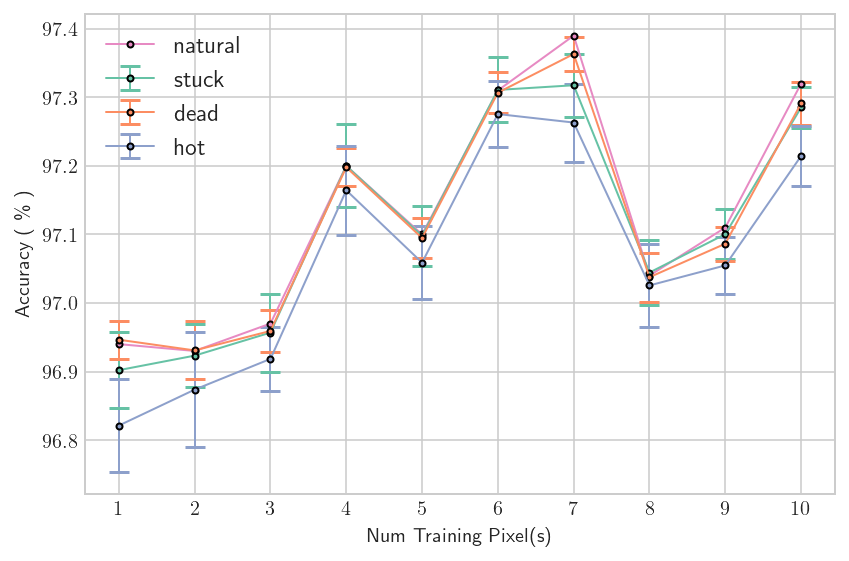

In [5]:
augmented_training(Xtrain, Ttrain, Xtest, Ttest, model='MNIST')

In [21]:
COLORS = pl.cm.Set2(np.linspace(0, 1, 8))

def augmented_training(Xtrain, Ttrain, Xtest, Ttest, model='MNIST'):

    if model == 'MNIST':
        mnist = True
        perturbs = ['stuck', 'dead', 'hot']
        training_vals = np.arange(1, 11)
        test_types = perturbs
        xlabel = 'Num Training Pixel(s)'
        test_pixel_change = 2
    else:
        mnist = False
        perturbs = ['noise']
        training_vals = np.linspace(0.001, 0.05, 1)
        test_types = [0.02550, 0.03775, 0.05000]
        xlabel = 'Training Variance of Noise'
        
    trials = 25
    
    f = FloatProgress(min=0, max=(len(perturbs) * len(training_vals) * (trials * len(test_types))))
    display(f)
    
    for i, perturb in enumerate(perturbs):
        
        natural_acc = []
        augmented_acc = np.zeros((len(test_types), 3, len(training_vals)))
        
        """
        test_perturb_1
        
               p_1 p_2 p_3 p_4
        mean [[0., 0., 0., 0.],
        std   [0., 0., 0., 0.]],
        
        test_perturn_2
        ...
        
        """
        
        for p, val in enumerate(training_vals):

            if mnist:
                Mtrain = per.change_pixel(Xtrain, pixels_to_change=val+1, pertrub=perturb)
                nnet = per.train_mnist(Mtrain, Ttrain)
            else:
                Mtrain = per.add_image_noise(Xtrain, val)
                nnet = per.train_cifar(Mtrain, Ttrain)
                
            natural_acc.append(ml.percent_correct(ml.batched_use(nnet, Xtest), Ttest))
            
            for t, test_perturb in enumerate(test_types):
                
                tmp = []
                
                for trial in range(trials):
                    if mnist:
                        M = per.change_pixel(Xtest, pixels_to_change=test_pixel_change, pertrub=test_perturb)
                    else:
                        M = per.add_image_noise(Xtest, test_perturb)
                    tmp.append(ml.percent_correct(ml.batched_use(nnet, M), Ttest))
                    f.value += 1
                    
                augmented_acc[t, 0, p] = np.mean(tmp)
                augmented_acc[t, 1, p] = np.std(tmp)
        
        print(perturb)
        
        for t, test_perturb in enumerate(test_types):
        
            plt.errorbar(training_vals, augmented_acc[t, 0], yerr=augmented_acc[t, 1],
                         marker='.', lw=1, capsize=5, capthick=1.5, label=f'{test_perturb}',
                         markeredgecolor='k', color=COLORS[t])
        
        plt.plot(training_vals, natural_acc, marker='.', lw=1, label=f'natural',
                 markeredgecolor='k', color=COLORS[3])
        
        plt.xticks(training_vals)
        plt.xlabel(xlabel)
        plt.ylabel('Accuracy ( \% )')
        plt.legend(loc='best', fontsize='large')
        plt.grid(True); plt.tight_layout();
        plt.savefig('media/constant/' + model + perturb + '.pdf', bbox_inches='tight')
        plt.show();

FloatProgress(value=0.0, max=2250.0)

stuck


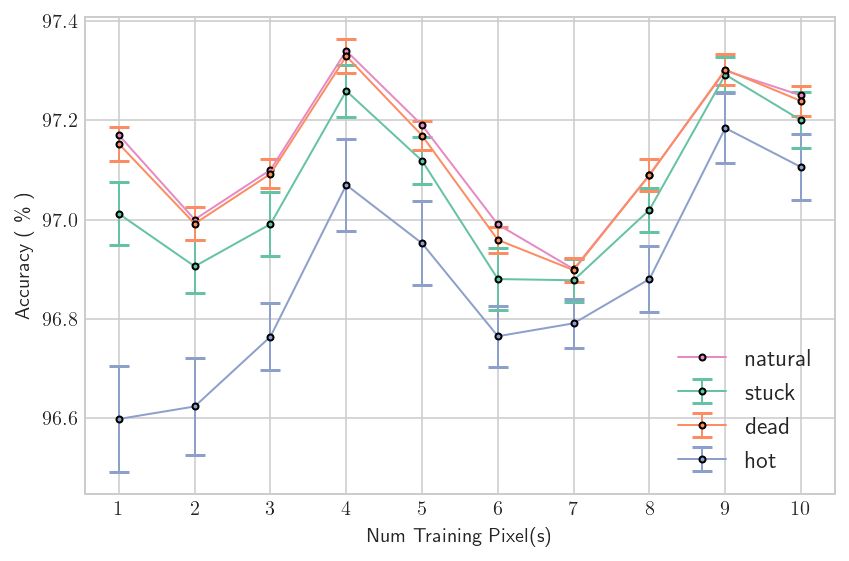

dead


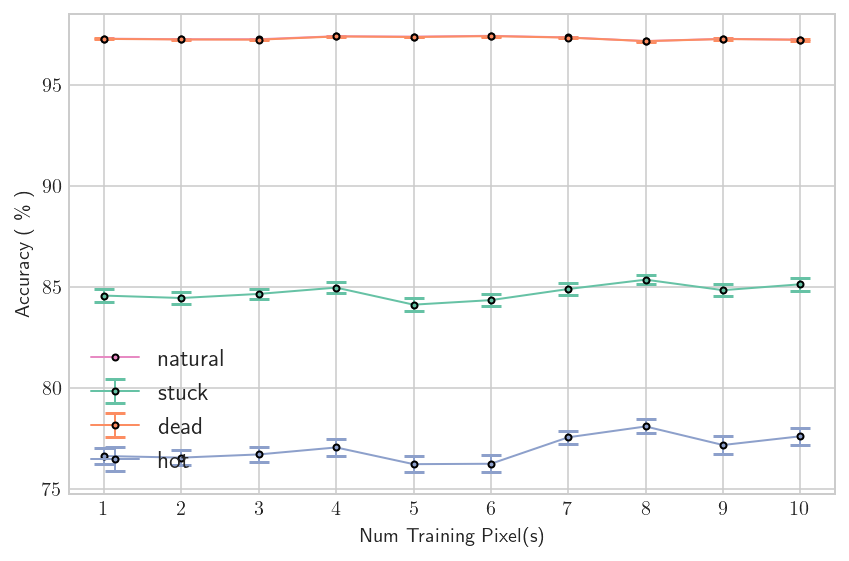

hot


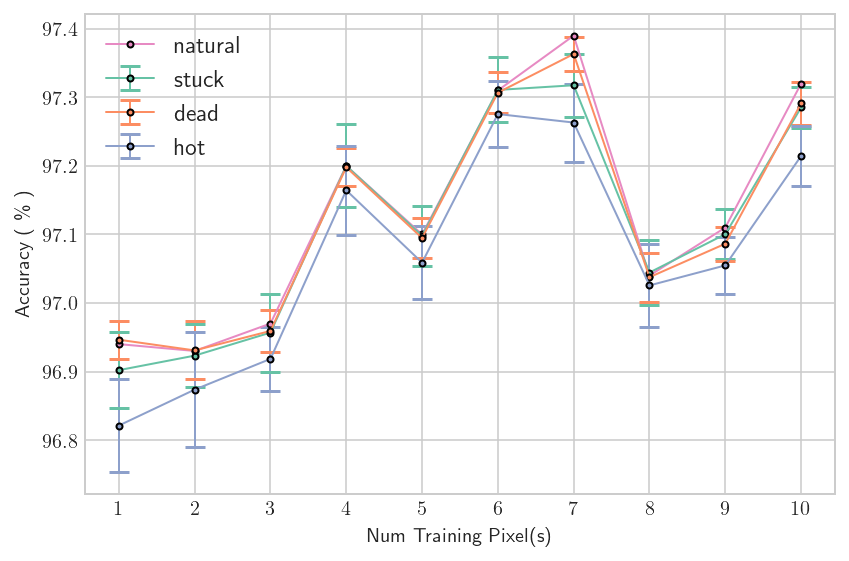

In [22]:
augmented_training(Xtrain, Ttrain, Xtest, Ttest, model='MNIST')